csv파일 전처리 과정  
pdf 형태의 파일을 인터넷의 pdf -> csv 를 통해 변환하였기에 판다스의 read_csv 명령어로 읽어오는 것이 불가능하여    
list형태로 읽어 다시 DataFrame형태에 맞추어 저장하도록함

In [ ]:
import csv
import pandas as pd
file_path = f'/content/ACPC2005.csv'
f = open(file_path, 'rt')
reader = csv.reader(f)

csv_list= []
for l in reader:
  csv_list.append(l)
f.close()

df = pd.DataFrame(csv_list)

위의 과정에서 csv파일을 전처리한 파일을 기준으로 Data를 가공하도록함  
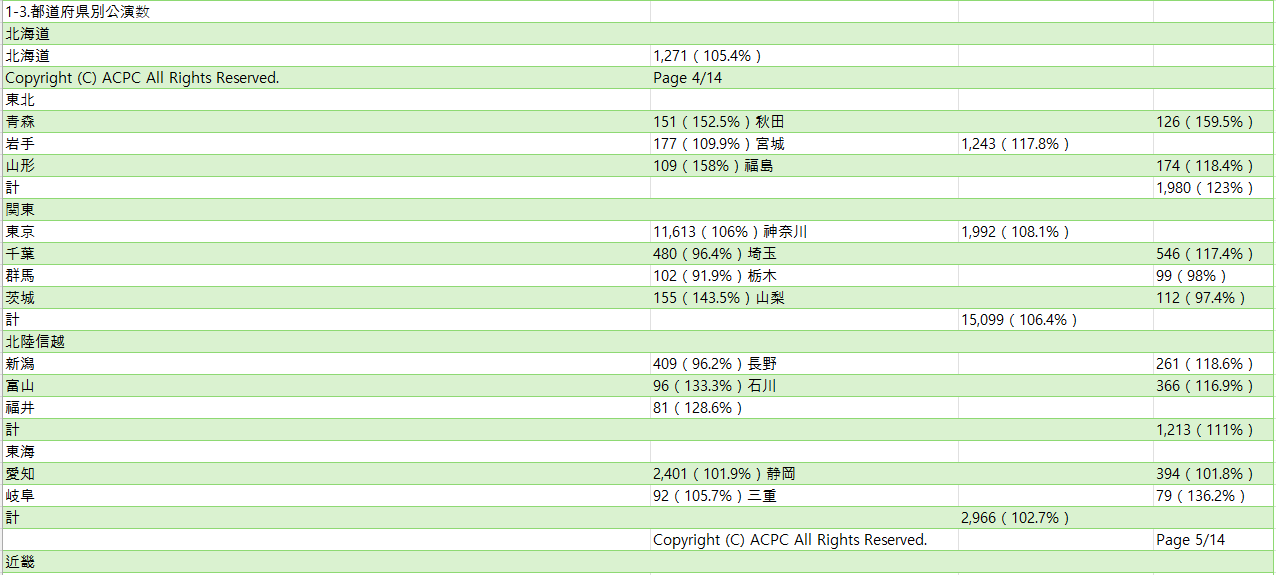  
파일이 본 형태와 같이 매우 난잡하여 관련한 전처리가 필요

In [ ]:
import csv
import pandas as pd
import numpy as np

data = pd.DataFrame()

for year in range(2005,2024):
  file_path = f'/content/ACPC{year}.csv'
  f = open(file_path, 'rt')
  reader = csv.reader(f)

  csv_list= []
  for l in reader:
    csv_list.append(l)
  f.close()

  df = pd.DataFrame(csv_list)
  df.columns = ['name','c1','c2','c3']

  #------------------------------------------------------------

  #천단위 구분표와 ()내부의 전년대비 증감량 삭제를 위한 함수
  def convert_value(x):
    x = x.split('（')[0]
    if x == '':
      return np.nan
    return x.replace(',','')

  #필요한 열 전까지의 데이터를 모두 날리도록 함
  #반복 사용되는 drop 이지만 함수처리 하지않은 이유는 함수처리시 중간이 비거나 시작열만 삭제하거나 하는등의 에러가 드문드문 일어남
  for i in range(df.index.get_loc(df[df['name']=='2-5.ジャンル別動員数（国内アーティスト）'].index[0])):
    df.drop(i,inplace=True)

  df.reset_index(inplace=True)
  df.drop('index',axis=1,inplace=True)

  #또한 사용할 데이터 이후 데이터또한 날리도록 함
  x = df.index.get_loc(df[df['name']=='2-7.海外アーティスト国籍別動員数'].index[0])
  y = df.shape[0]

  for x in range(x,y):
    df.drop(x,inplace=True)

  #이름이 들어가있는 열을 제외한 열 3개에 랜덤하게 위치되어있는 값들을 한곳으로 모아 처리하도록 함
  df.fillna('',inplace=True)

  df['total'] = df['c1'].map(str) + df['c2'].map(str) + df['c3'].map(str)
  df.drop(['c1','c2','c3'],axis=1,inplace=True)

  #모아진 데이터에서 매핑을 통하여 천단위 구분표와 전년대비 백분율이 필요하지않아 천단위 구분자와 백분율을 제거하도록 함
  df['total'] = df['total'].map(convert_value)

  #이후 몇몇 데이터중 copyright 를 기준으로 데이터가 나누어지는 경우가 생겨 해당인덱스를 제거하도록 함
  x = df.index.get_loc(df[df['name']=='Copyright (C) ACPC All Rights Reserved.'].index[0])
  df.drop(x,inplace=True)
  df.dropna(inplace=True)

  #이후 name 열은 사용하지 않고 name의 내용을 한국어로 번역하여 index로 사용할것이므로 삭제하도록 함
  df.drop('name',inplace=True,axis=1)
  df.reset_index(inplace=True)
  df.drop('index',axis=1,inplace=True)

  #데이터가 해외의 연주자, 국내의 연주자가 따로 나누어져있었으나 시각화에서 크게 필요하지 않은 정보이며 통합정보가 필요하였기에 둘을 합치도록 함
  df['total'].astype('int64')
  df[year] = np.nan
  for i in range(7):
    df.loc[i,year] = int(df['total'][i]) + int(df['total'][i+7])

  #국내연주자,해외연주자의 값이 따로 존재하던 컬럼을 삭제하고 합산값이 na인 해외 연주자의 row를 삭제하도록 함
  df.drop('total',inplace=True,axis=1)
  df.dropna(inplace=True)

  df = df[year].astype('int64')
  df.rename(index={0:'록',1:'가요곡/연가',2:'재즈/퓨전',3:'클래식',4:'공연예술',5:'그외',6:'총인원수'},inplace=True)

  if year == 2005:
    data = df
  else:
    data = pd.concat([data,df],axis=1)

data.to_csv('ACPC2005-2023.csv')


,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
록,15411780,15455526,15558345,18392055,22285908,20300029,21474171,25149821,31587721,32673466,35350275,33605786,36466059,37084913,37848738,8080290,15522412,35289890,43791092
가요곡/연가,1435575,1357538,877050,797814,722665,713538,883213,831122,1509908,1345751,1421150,1460359,1343798,1502324,1391403,264507,543491,1518909,1090238
재즈/퓨전,339316,325236,294199,262504,217620,142938,141705,137119,168430,131345,72116,80377,63599,49770,67374,13533,80906,132064,120090
클래식,199717,239280,259442,286968,421277,325724,318529,310181,460828,640776,494867,740566,810421,678229,636556,243301,439784,773291,767073
공연예술,1690713,1000396,2497718,1952812,1491446,2912821,2737652,2100396,4228169,4840255,5237792,5218333,5346125,4933283,4745293,1585219,3381274,5083645,5600876


가공이후
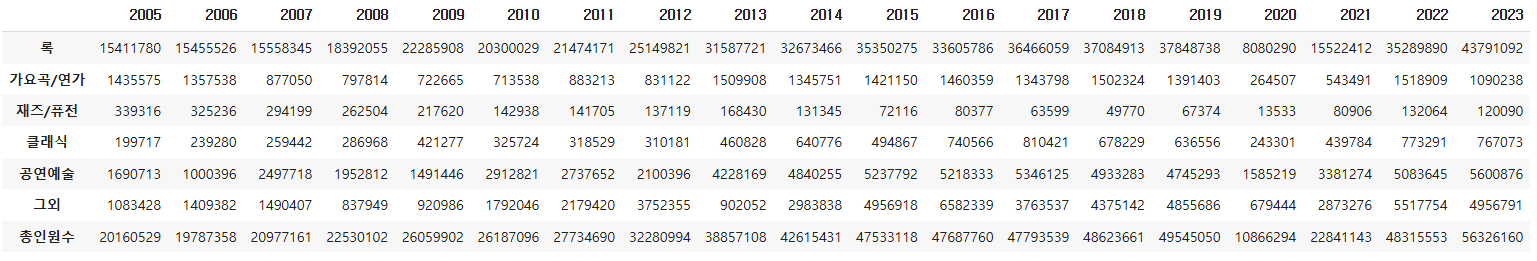

시각화 과정

In [ ]:
# 단계 1: 폰트 설치
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
!apt-get -qq -y install fonts-nanum > /dev/null
#fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

#font = fm.FontProperties(fname=fontpath, size=9)

#fm._rebuild()



fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'}) # 폰트 설


In [ ]:
# 단계 2: 런타임 재시작
import os
os.kill(os.getpid(), 9)

In [ ]:
# 단계 3: 한글 폰트 설정
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

# 마이너스 표시 문제
mpl.rcParams['axes.unicode_minus'] = False

# 한글 폰트 설정
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 13, 'font.family': 'NanumGothic'}) # 폰트 설

In [ ]:
import pandas as pd
import numpy as np
data = pd.read_csv('/content/ACPC2005-2023.csv',index_col=0)

,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
록,15411780,15455526,15558345,18392055,22285908,20300029,21474171,25149821,31587721,32673466,35350275,33605786,36466059,37084913,37848738,8080290,15522412,35289890,43791092
가요곡/연가,1435575,1357538,877050,797814,722665,713538,883213,831122,1509908,1345751,1421150,1460359,1343798,1502324,1391403,264507,543491,1518909,1090238
재즈/퓨전,339316,325236,294199,262504,217620,142938,141705,137119,168430,131345,72116,80377,63599,49770,67374,13533,80906,132064,120090
클래식,199717,239280,259442,286968,421277,325724,318529,310181,460828,640776,494867,740566,810421,678229,636556,243301,439784,773291,767073
공연예술,1690713,1000396,2497718,1952812,1491446,2912821,2737652,2100396,4228169,4840255,5237792,5218333,5346125,4933283,4745293,1585219,3381274,5083645,5600876


음악 총 인구의 인구 변화

<ipython-input-34-2b2ef7ade6a6>:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f'{int(x/10000)}만' for x in current_values])


[Text(0, 0.0, '0만'),
 Text(0, 10000000.0, '1000만'),
 Text(0, 20000000.0, '2000만'),
 Text(0, 30000000.0, '3000만'),
 Text(0, 40000000.0, '4000만'),
 Text(0, 50000000.0, '5000만'),
 Text(0, 60000000.0, '6000만')]

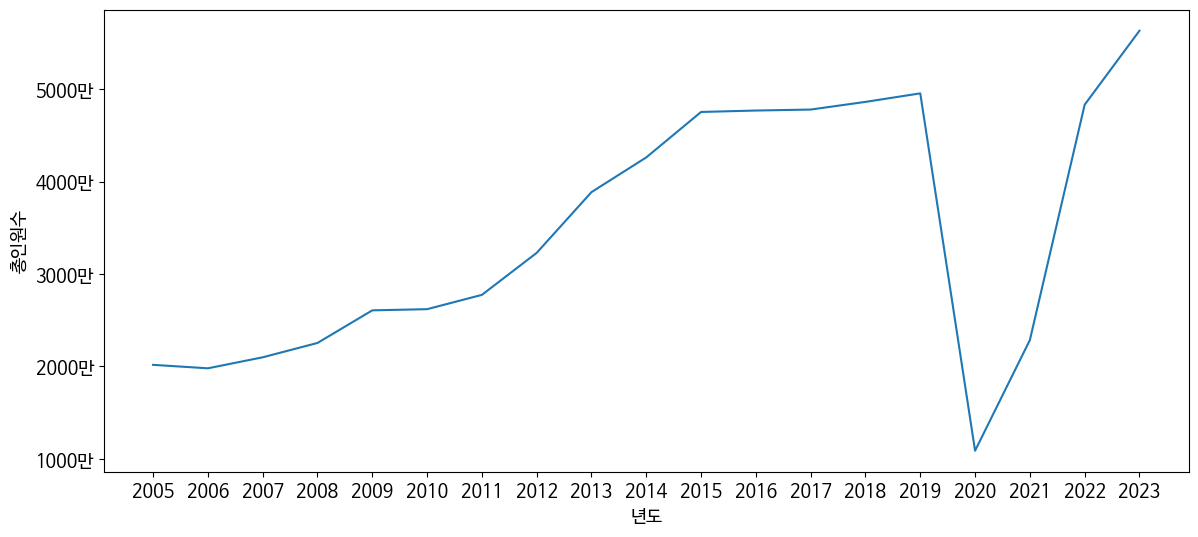

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
df = data.T
df['년도'] = [df for df in df.index]
plt.figure(figsize=(14,6))
sns.lineplot(data=df,x='년도',y='총인원수')
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels([f'{int(x/10000)}만' for x in current_values])

클래식 음악 인구의 변화

<ipython-input-35-bfe7c56b4870>:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f'{int(x/10000)}만' for x in current_values])


[Text(0, 100000.0, '10만'),
 Text(0, 200000.0, '20만'),
 Text(0, 300000.0, '30만'),
 Text(0, 400000.0, '40만'),
 Text(0, 500000.0, '50만'),
 Text(0, 600000.0, '60만'),
 Text(0, 700000.0, '70만'),
 Text(0, 800000.0, '80만'),
 Text(0, 900000.0, '90만')]

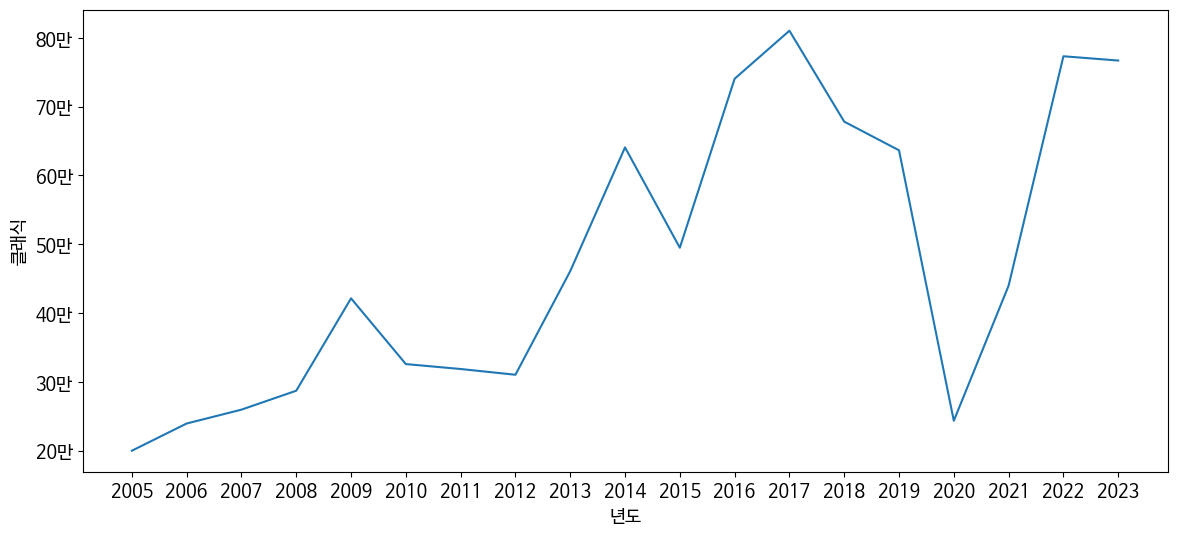

In [ ]:
plt.figure(figsize=(14,6))
sns.lineplot(data=df,x='년도',y='클래식')
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels([f'{int(x/10000)}만' for x in current_values])

가장 클래식 인구가 많았던 순간의 클래식 인구 비율

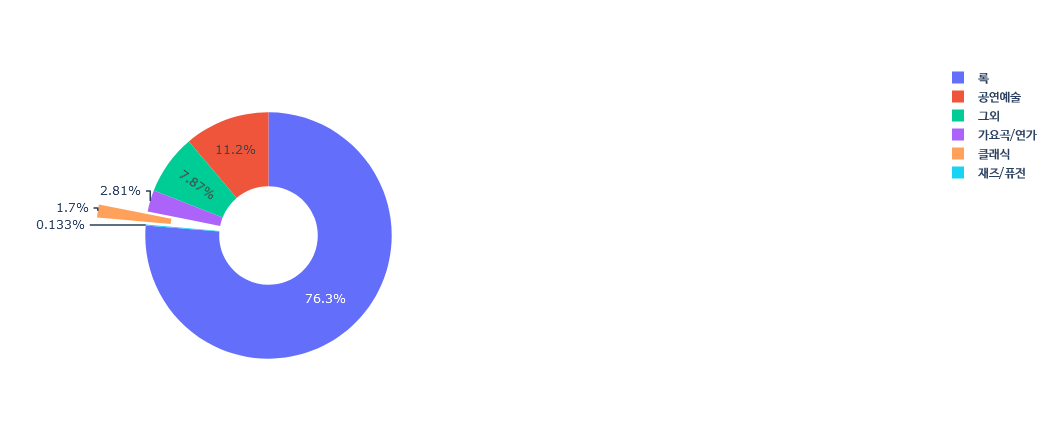

In [ ]:
import plotly.express as px
cdata = data.drop('총인원수')
fig = px.pie(cdata, values='2017', names=cdata.index, title='2017')
fig.update_traces(pull=[0, 0, 0, 0.4,0,0])
fig.update_traces(hole=.4)
fig.show()
fig.write_html('2017.html')

과거의 클래식 인구 비율

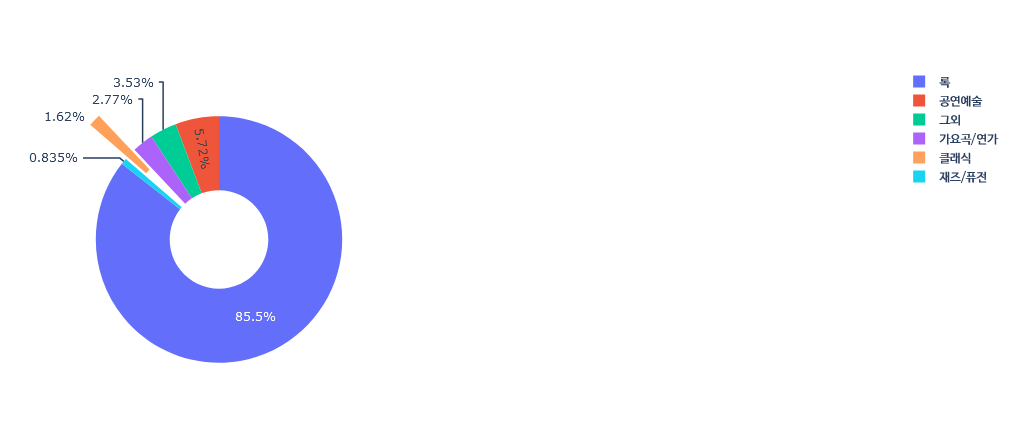

In [ ]:
fig = px.pie(cdata, values='2009', names=cdata.index, title='2009')
fig.update_traces(pull=[0, 0, 0, 0.4,0,0])
fig.update_traces(hole=.4)
fig.show()

코로나 당시의 클래식 인구

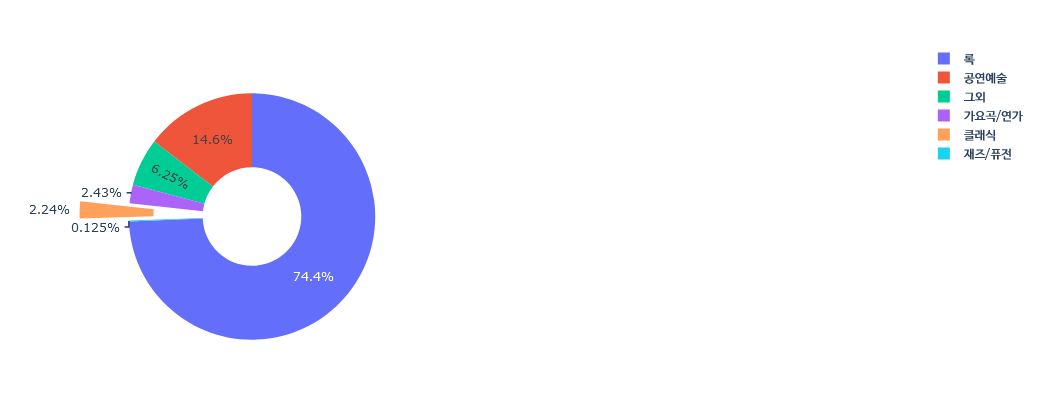

In [ ]:
fig = px.pie(cdata, values='2020', names=cdata.index, title='2020')
fig.update_traces(pull=[0, 0, 0, 0.4,0,0])
fig.update_traces(hole=.4)
fig.show()